In [1]:
#############################################################################
# zlib License
#
# (C) 2023 Zach Flowers, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

# Imports

In [2]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import time
from tqdm import tqdm
# from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
import datetime
import pandas as pd
from pathlib import Path
import subprocess
import sqlite3
from notebooks.notebook_helpers import *
from fnmatch import fnmatch
import scipy.stats as stats
from math import ceil
from numpy import savetxt
from scripts.log_action import log_action_v2
from time import sleep
from matplotlib.dates import DateFormatter
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
import parser_arguments
import importlib
importlib.reload(run_script)

<module 'run_script' from '/home/daq/ETROC2/ETROC_DAQ/run_script.py'>

# Set defaults

In [3]:
# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
chip_names = ["ET2_EPIR_Pair1", "ET2p01_BAR_4", "ET2p01_BAR_6", "ET2_EPIR_Pair4"]
chip_fignames = ["ET2 EPIR Pair 1", "ET2.01 Barcelona 4", "ET2.01 Barcelona 6", "ET2 EPIR Pair4"]
chip_names = ["ET2_EPIR_Pair1", "ET2p01_BAR_4", "ET2p01_BAR_5", "ET2_EPIR_Pair4"]
chip_fignames = ["ET2 EPIR Pair 1", "ET2.01 Barcelona 4", "ET2.01 Barcelona 5", "ET2 EPIR Pair4"]
chip_figtitles = chip_names
chip_addresses = [0x60, 0x61, 0x62, 0X63]

fig_outdir = Path('../ETROC-figures')
fig_outdir = fig_outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
fig_outdir.mkdir(exist_ok=True)
fig_path = str(fig_outdir)

today = datetime.date.today().isoformat()

In [4]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.show()

<Figure size 1000x1000 with 0 Axes>

# Define pixels of interest

In [5]:

row_list = [14, 14, 14, 8, 8, 8, 2, 2, 2]
col_list = [14,  8,  2, 14,8, 2,14, 8, 2]

scan_list = list(zip(row_list, col_list))

print(scan_list)

[(14, 14), (14, 8), (14, 2), (8, 14), (8, 8), (8, 2), (2, 14), (2, 8), (2, 2)]


### func for plotting

In [6]:
def makePlot(var, inputname, scan_pixels, timestamp_cut=None, note_cut=None, label=None, df=None):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(24,9))
    ax.set_prop_cycle(color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999'])

    i = 0

    threshold_timestamp = pd.Timestamp(timestamp_cut)
    for row, col in scan_pixels:
        filtered_df = df[(df['chip_name'] == inputname) & (df['row'] == row) & (df['col'] == col) & (df['baseline'] != 0)].copy()
        # filtered_df = df[(df['chip_name'] == inputname) & df.loc[row_indexer,col_indexer]  & (df['baseline'] != 0)]
        filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])

        if note_cut is not None:
            filtered_df = filtered_df[filtered_df['note'].str.contains(note_cut)]
        if timestamp_cut is not None:
            filtered_df = filtered_df.loc[filtered_df['timestamp'] > threshold_timestamp]

        hep.cms.text(loc=0, ax=ax, text="Preliminary", fontsize=25)
        if label is not None:
            ax.set_title(label, size=17, loc="right")
        ax.plot(filtered_df['timestamp'], filtered_df[var], '.-', label=f'Row-Col = ({row}-{col})')

        # Set x-axis labels with line breaks using LaTeX notation
        if i == 0:
            date_form = DateFormatter("%Y-%m-%d %H:%M")
            ax.xaxis.set_major_formatter(date_form)
            plt.xticks(rotation=60)
            # x_labels = [f'{row["note"].replace(f"_{chip_name}","")}\n{row["timestamp"].strftime("%Y-%m-%d %H:%M")}' for index, row in filtered_df.iterrows()]
            # ax.set_xticks(filtered_df['timestamp'])
            # ax.set_xticklabels(x_labels, rotation=90, fontsize=9)

        i += 1

    ax.grid(which='both', axis='y')
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.legend(ncols=2, fontsize=14)

    var_label = str(var).replace('_', ' ')

    # Set labels for other axes as needed
    ax.set_ylabel(f'{inputname} {var_label}')

### run plotting

In [7]:
histdir = Path('/media/daq/X9/ETROC-History-DESY-Feb-2024/')
histdir.mkdir(exist_ok=True)
# histfile = histdir / 'BaselineHistory_test.sqlite'
histfile = histdir / 'FullBaselineHistory.sqlite'

row_list = [14, 14, 14, 8, 8, 8, 2, 2, 2]
col_list = [14,  8,  2, 14,8, 2,14, 8, 2]

scan_list = list(zip(row_list, col_list))

print(scan_list)

[(14, 14), (14, 8), (14, 2), (8, 14), (8, 8), (8, 2), (2, 14), (2, 8), (2, 2)]


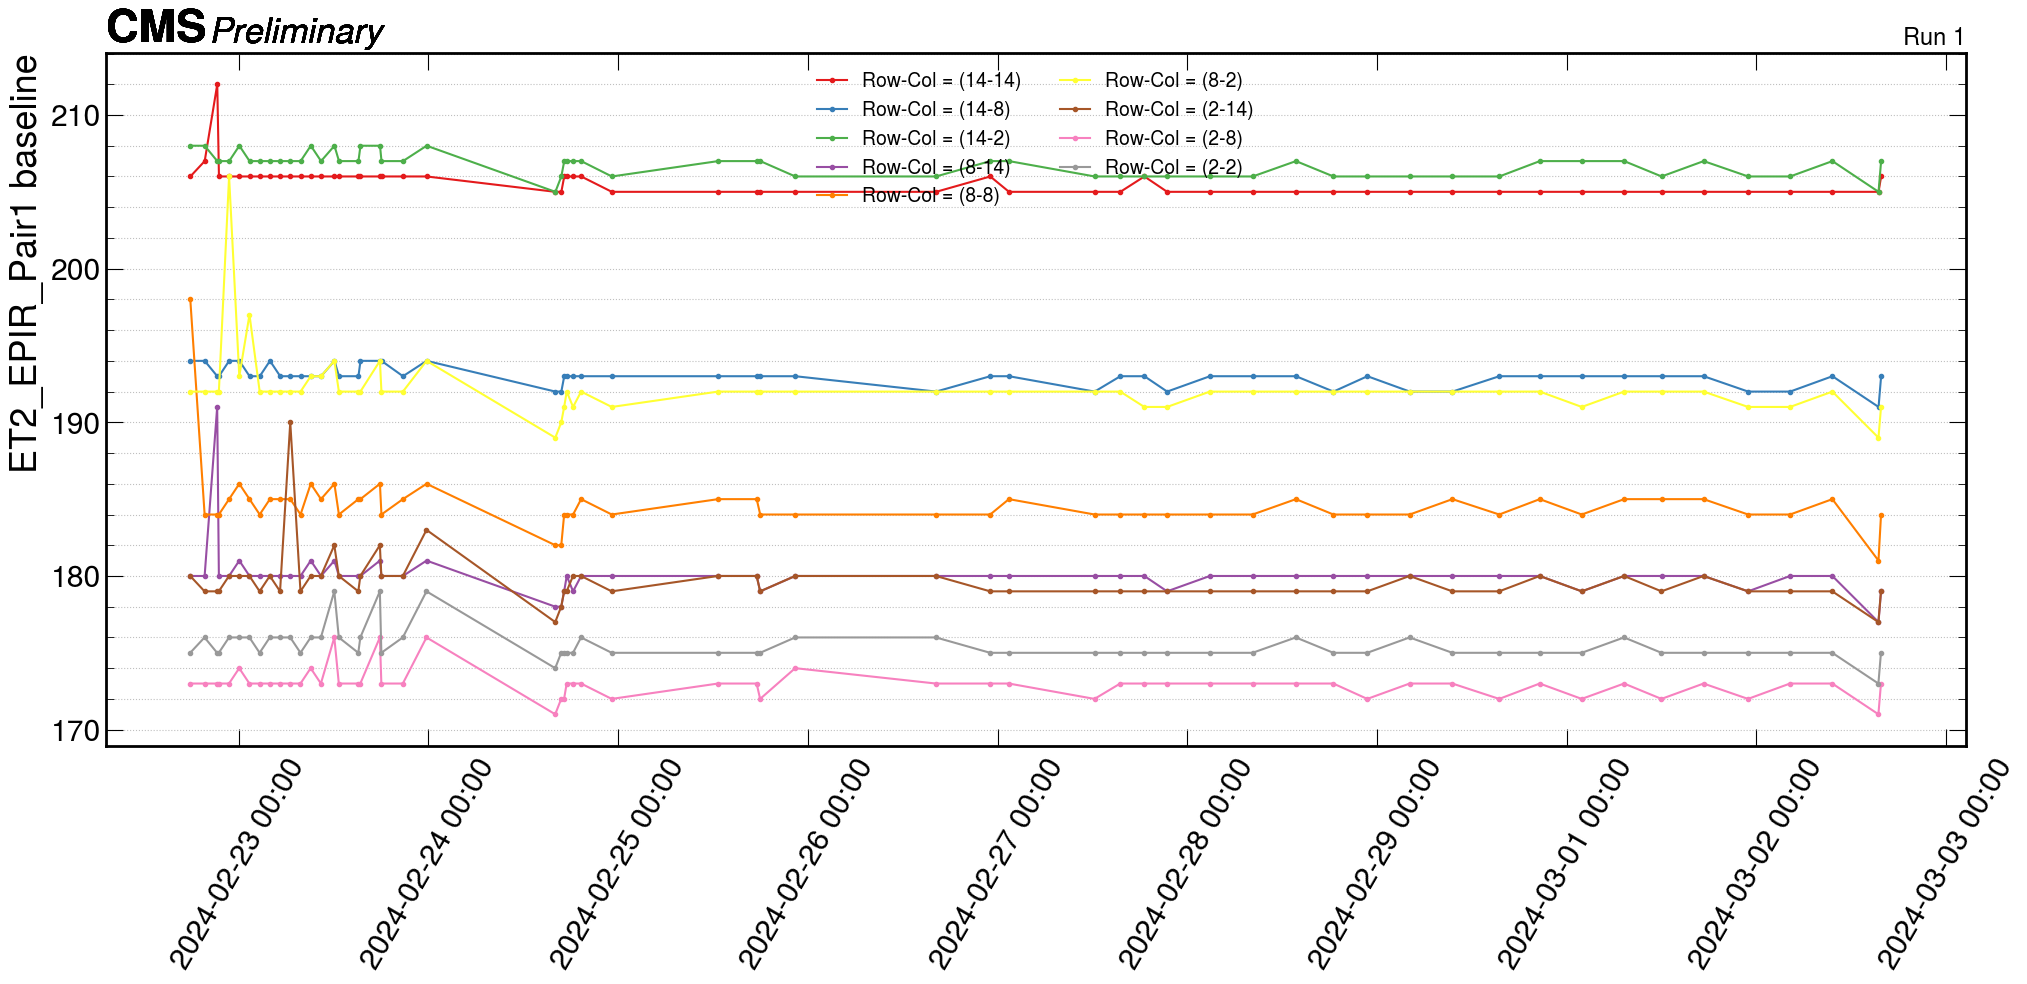

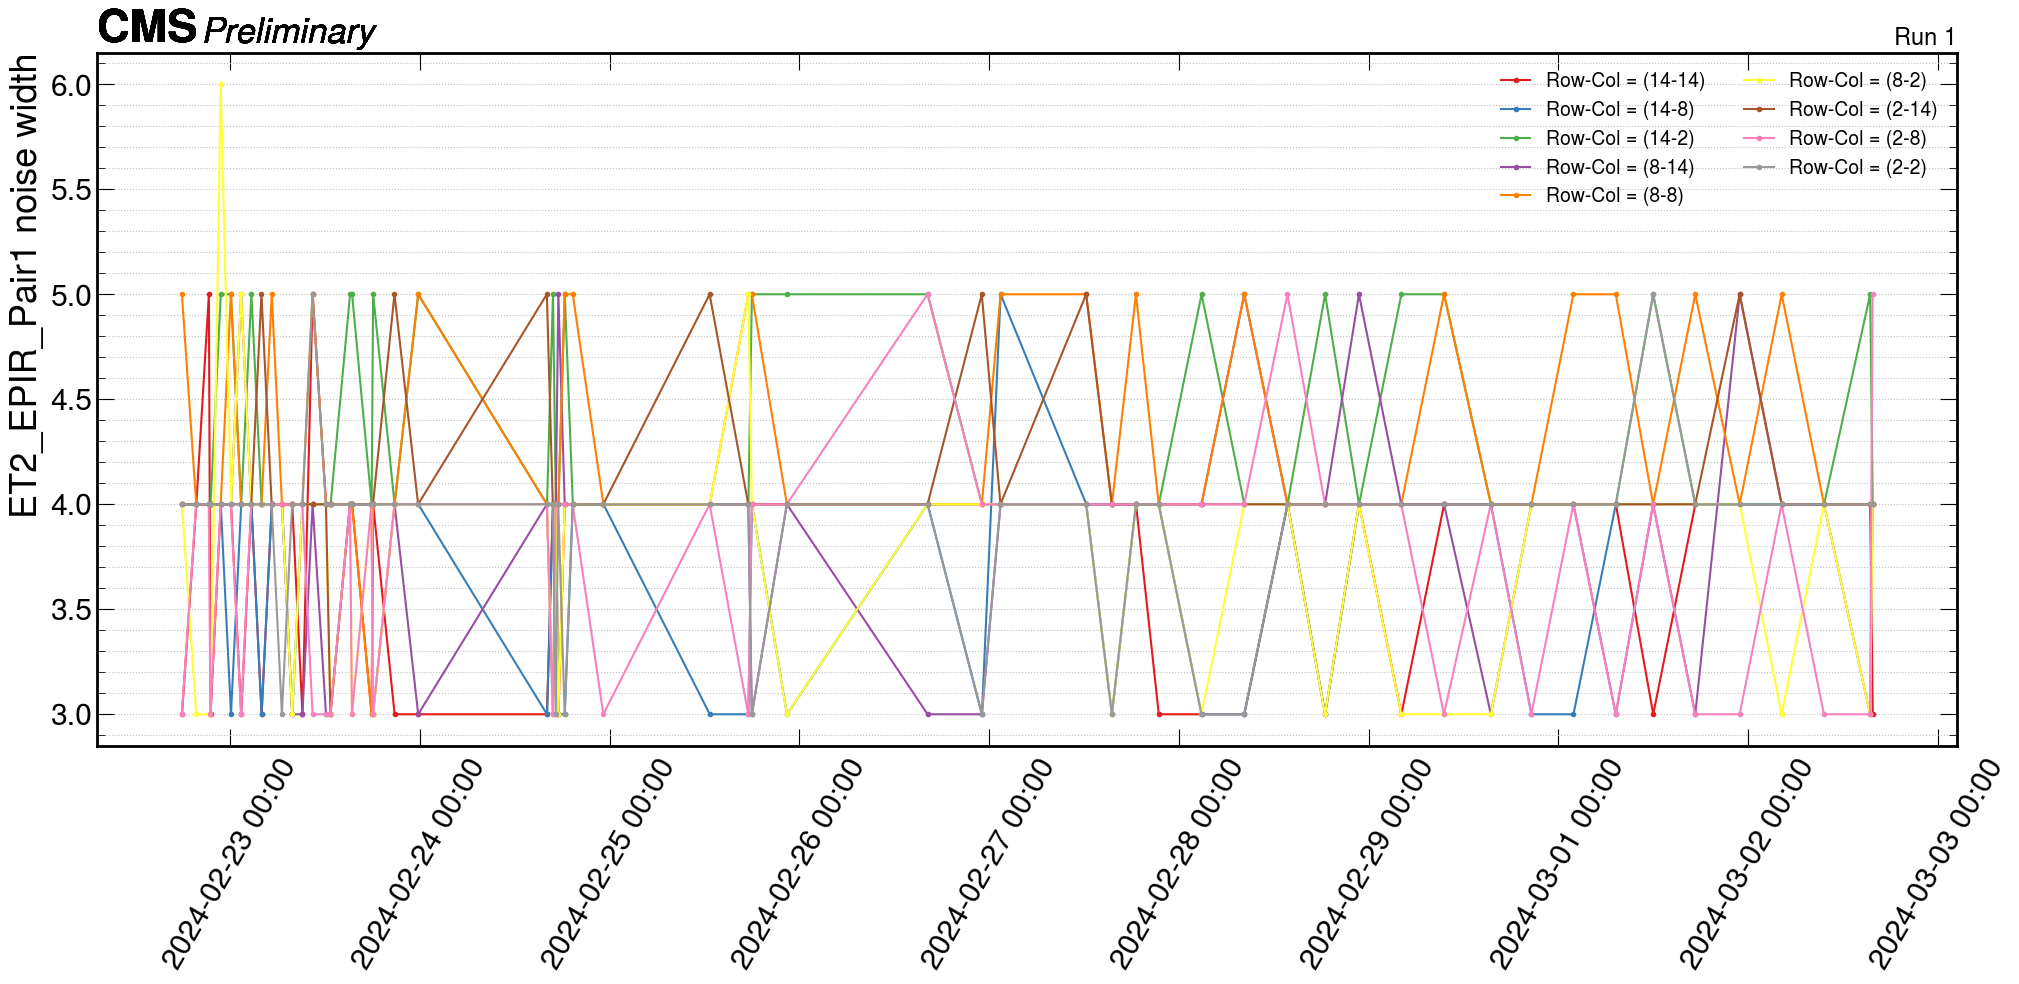

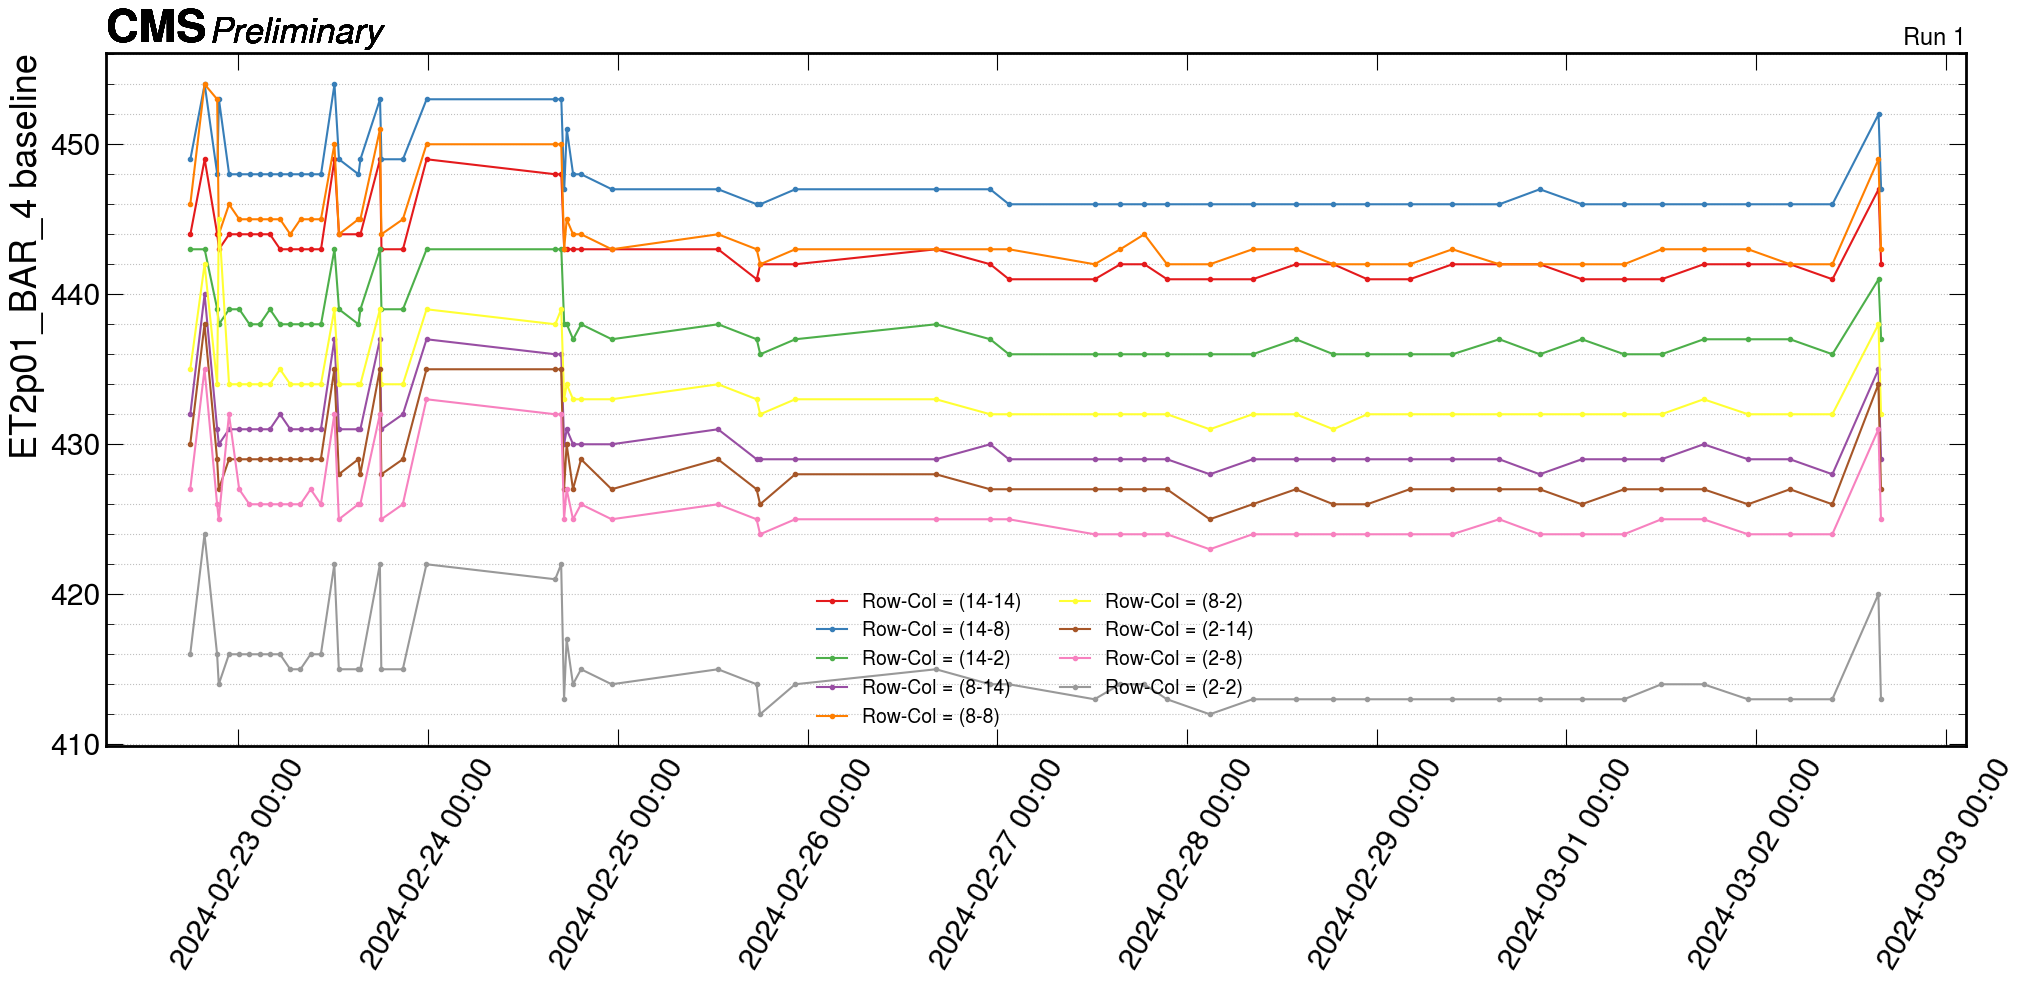

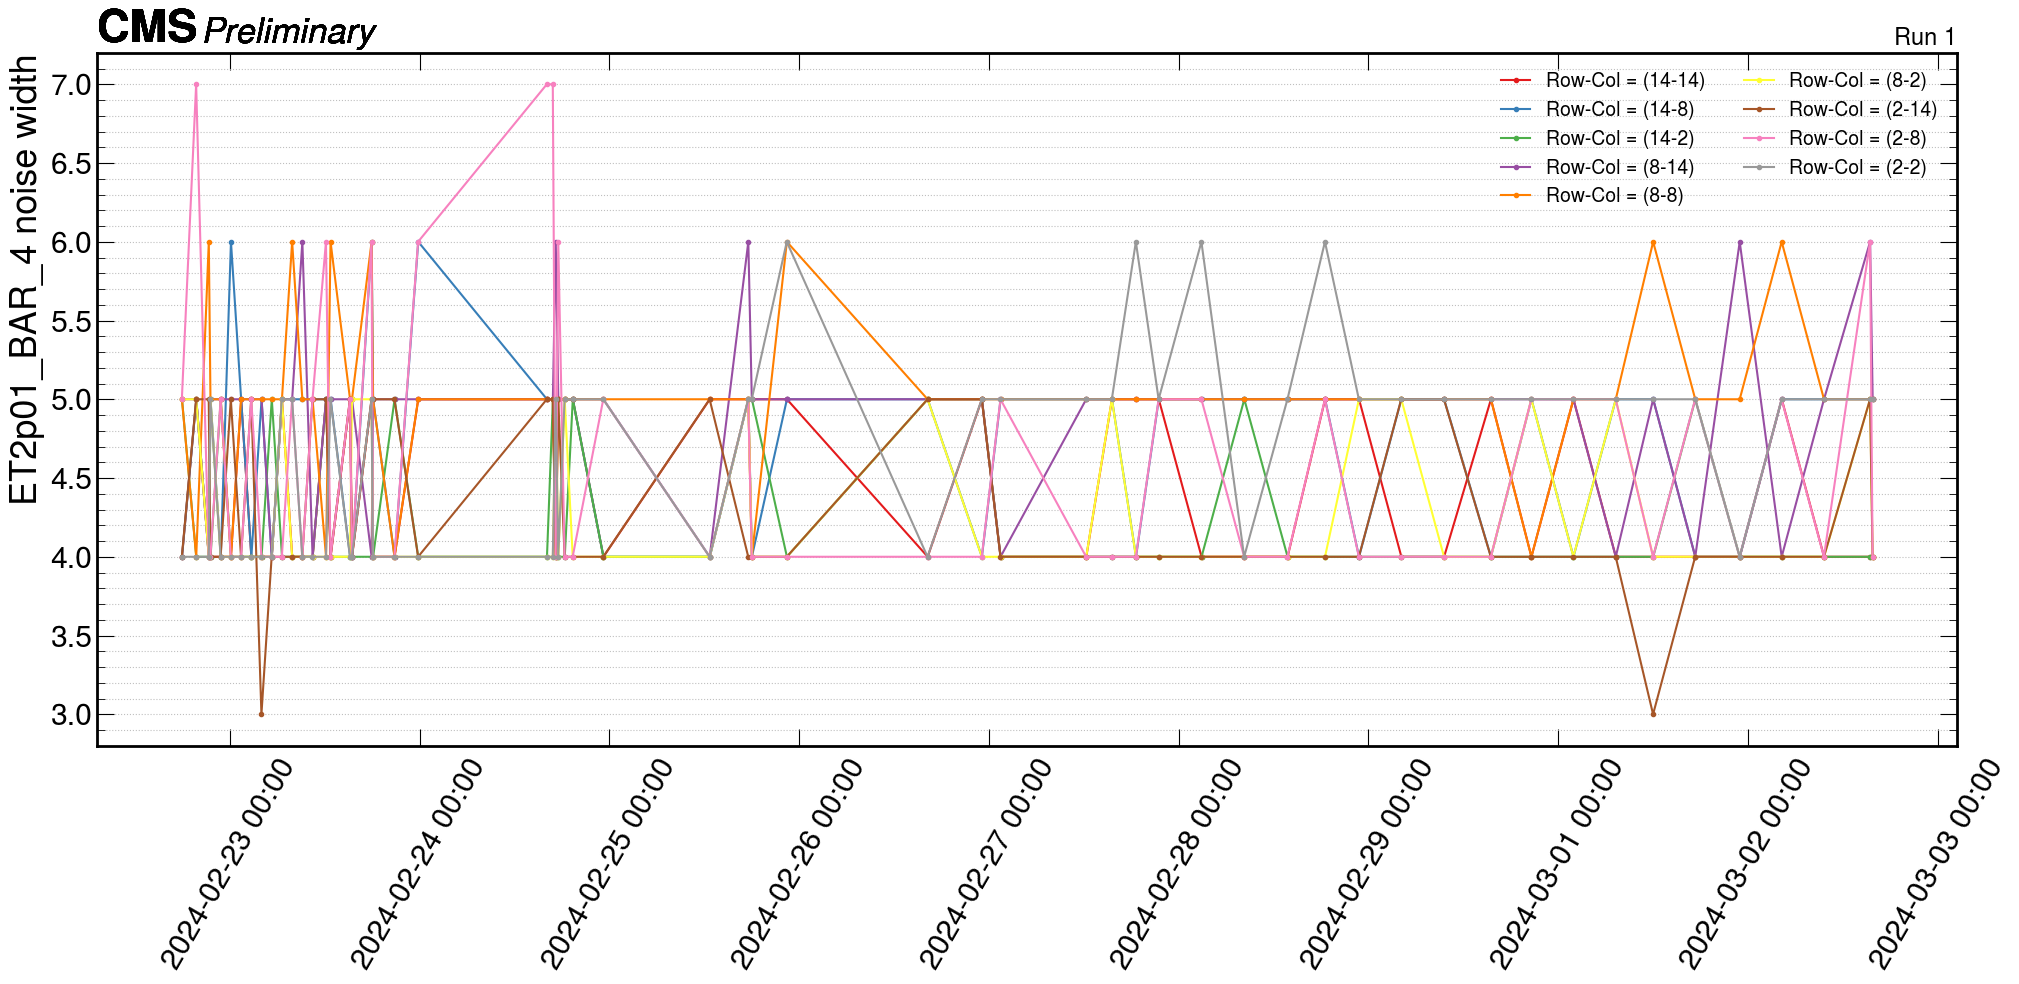

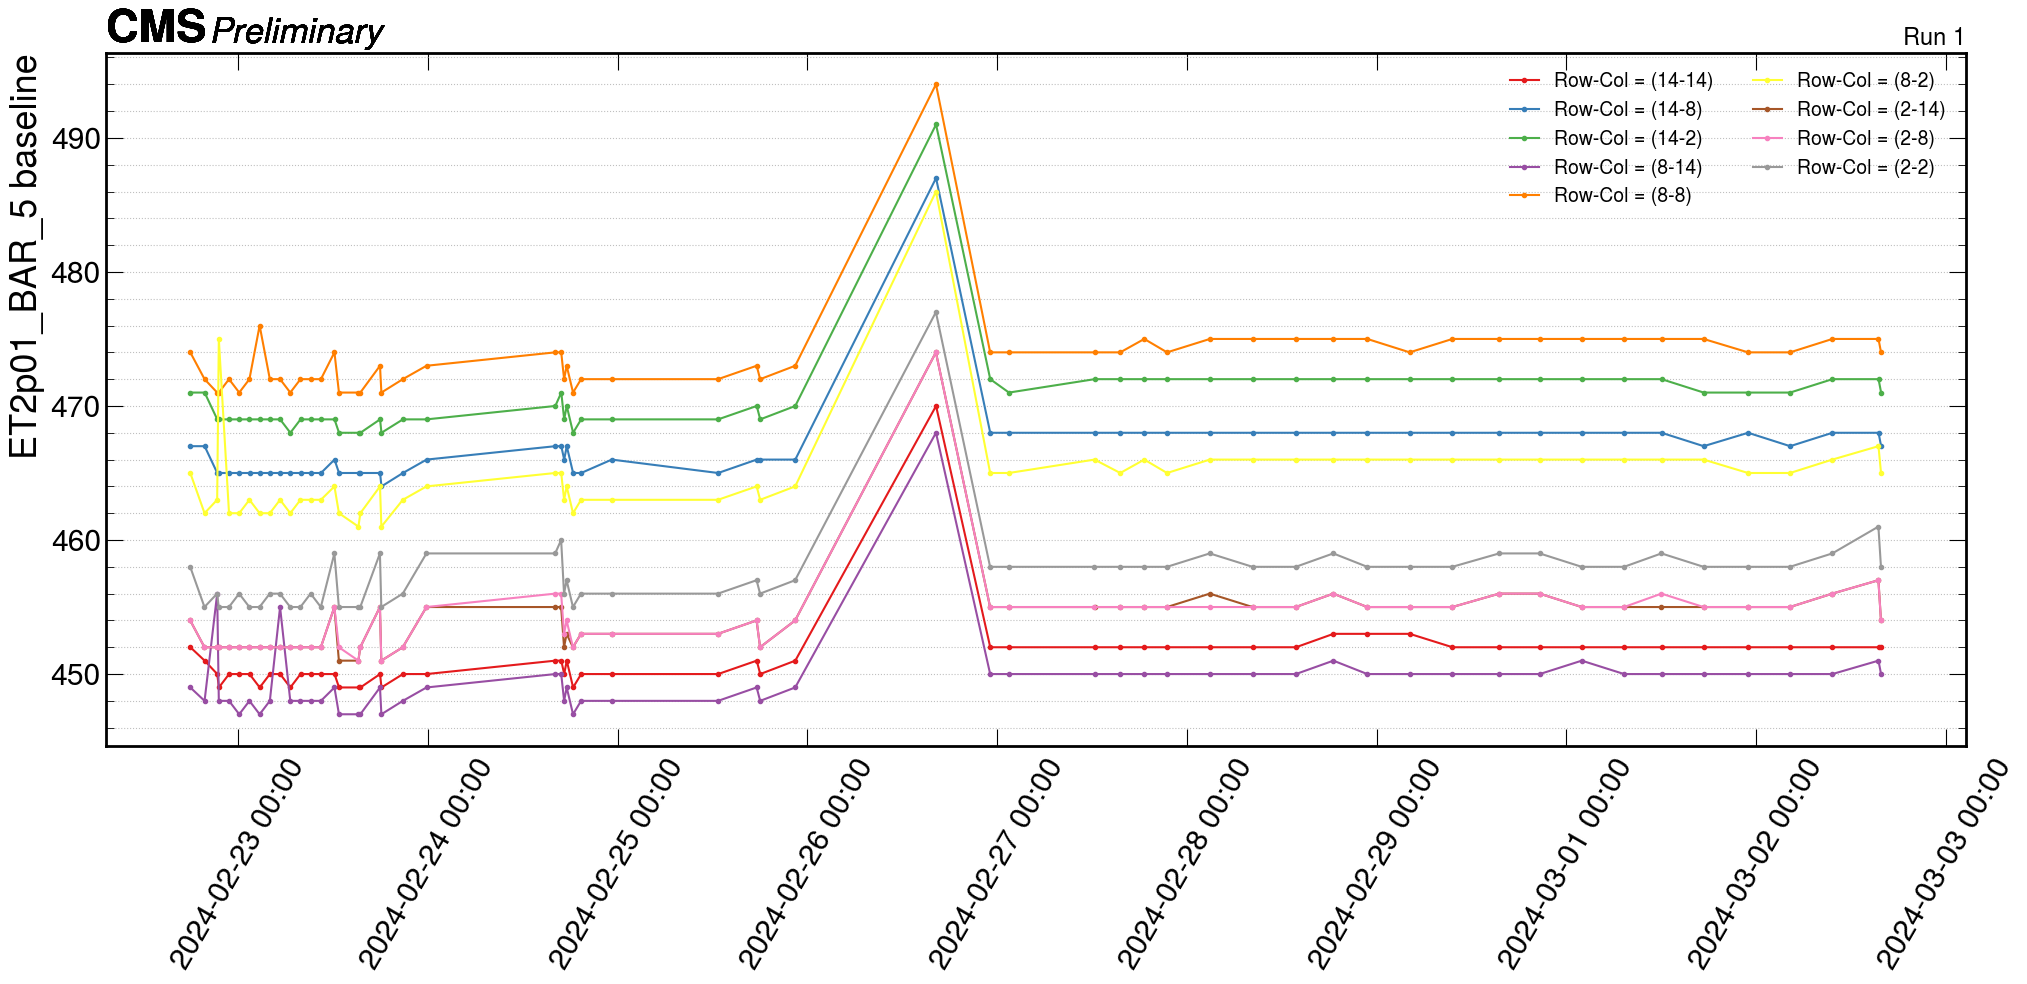

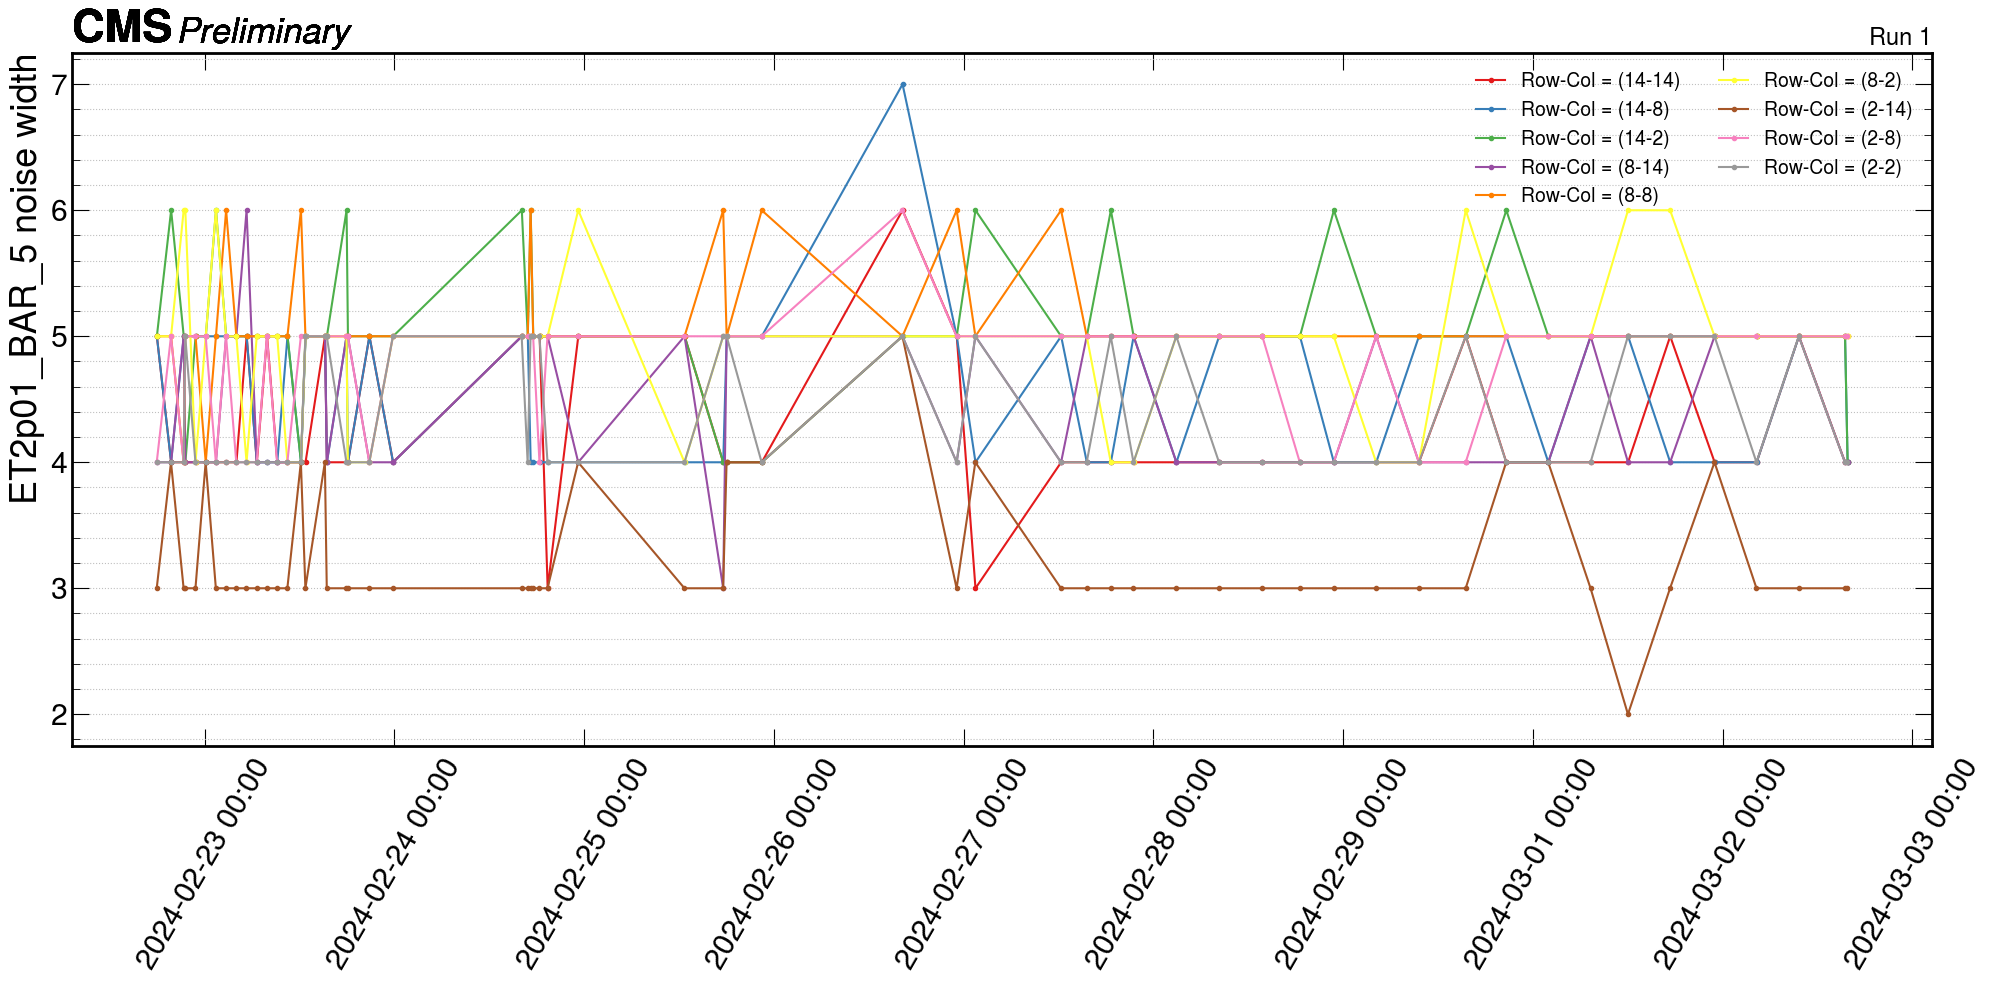

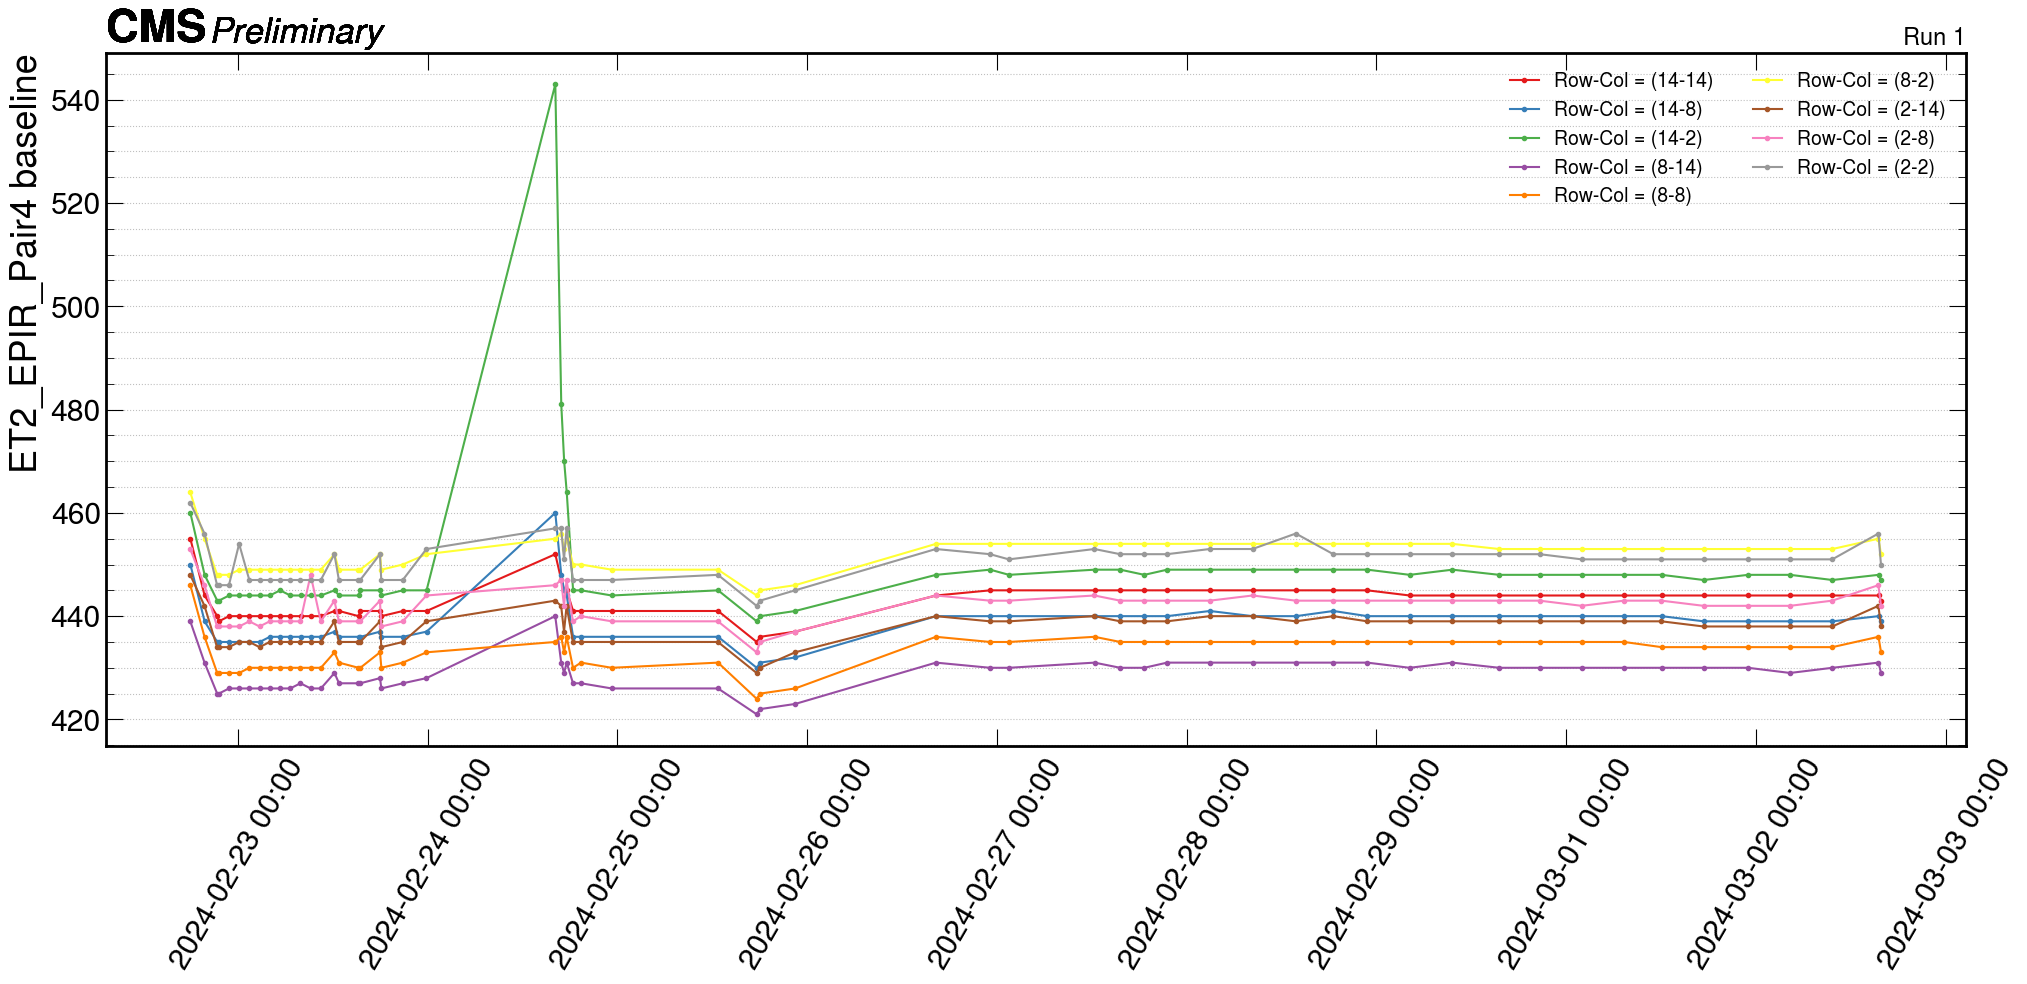

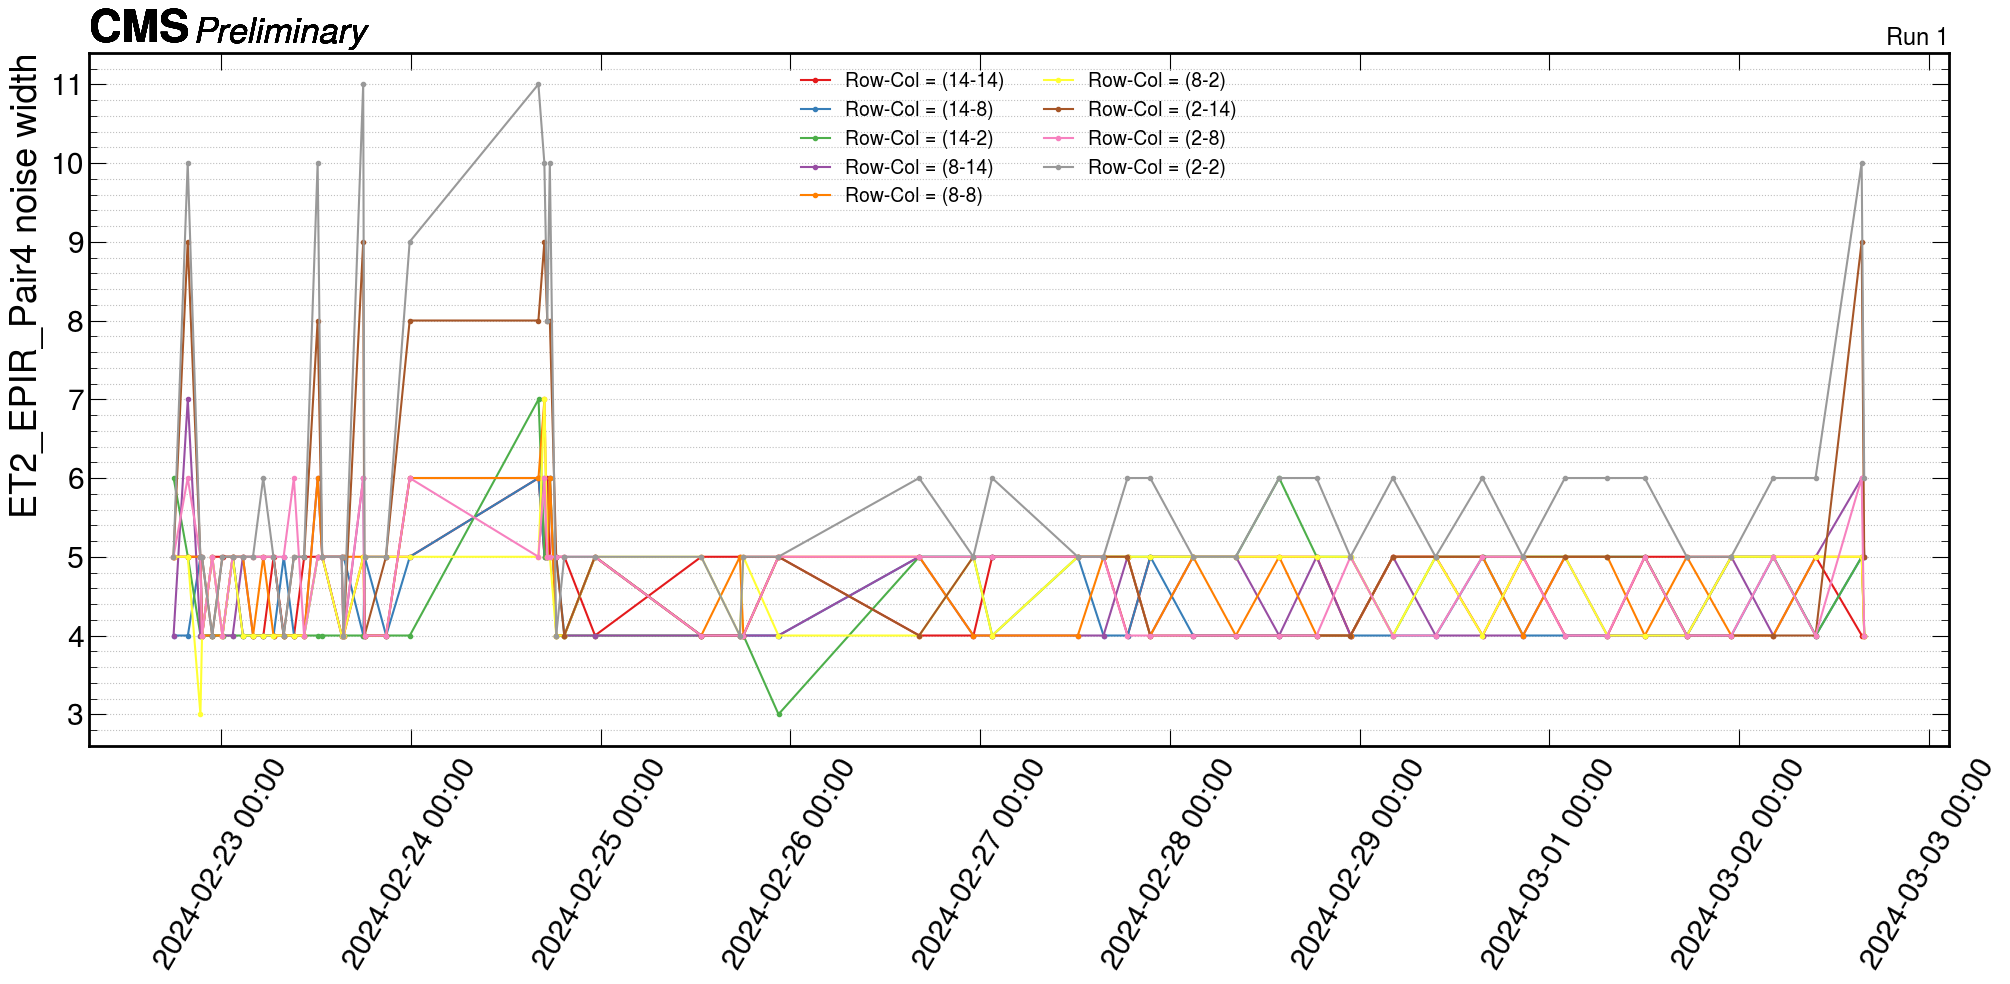

In [8]:
chip_names = ["ET2_EPIR_Pair1", "ET2p01_BAR_4", "ET2p01_BAR_6", "ET2_EPIR_Pair4"]
chip_fignames = ["ET2 EPIR Pair 1", "ET2.01 Barcelona 4", "ET2.01 Barcelona 6", "ET2 EPIR Pair4"]
chip_names = ["ET2_EPIR_Pair1", "ET2p01_BAR_4", "ET2p01_BAR_5", "ET2_EPIR_Pair4"]
chip_fignames = ["ET2 EPIR Pair 1", "ET2.01 Barcelona 4", "ET2.01 Barcelona 5", "ET2 EPIR Pair4"]

con = sqlite3.connect(histfile)
df = pd.read_sql_query("SELECT * from baselines", con)

time_cut = None
note_cut = None
label = 'Run 1' # Feb 20 test run in the open no chiller

for chip_name in chip_names:
    makePlot('baseline', chip_name, scan_list, time_cut, note_cut, label, df)
    makePlot('noise_width', chip_name, scan_list, time_cut, note_cut, label, df)

In [ ]:
chip_names = ["ET2_EPIR_Pair1", "ET2p01_BAR_4", "ET2p01_BAR_6", "ET2_EPIR_Pair4"]
chip_fignames = ["ET2 EPIR Pair 1", "ET2.01 Barcelona 4", "ET2.01 Barcelona 6", "ET2 EPIR Pair4"]

con = sqlite3.connect(histfile)
df = pd.read_sql_query("SELECT * from baselines", con)

time_cut = None
note_cut = "PreBeam_BLmonitoring_nochiller_plastic" # Feb 20 first run with black plastic no chiller
label = 'Run 1'

for chip_name in chip_names:
    makePlot('baseline', chip_name, scan_list, time_cut, note_cut, label, df)
    makePlot('noise_width', chip_name, scan_list, time_cut, note_cut, label, df)

In [ ]:
chip_names = ["ET2_EPIR_Pair1", "ET2p01_BAR_4", "ET2p01_BAR_6", "ET2_EPIR_Pair4"]
chip_fignames = ["ET2 EPIR Pair 1", "ET2.01 Barcelona 4", "ET2.01 Barcelona 6", "ET2 EPIR Pair4"]

con = sqlite3.connect(histfile)
df = pd.read_sql_query("SELECT * from baselines", con)

time_cut = None # '2024-01-17 11:57:00'
note_cut = "PreBeam_BLmonitoring_withchiller12c" # First run with plastic and cooling at 12 C
label = 'Run 1'

for chip_name in chip_names:
    makePlot('baseline', chip_name, scan_list, time_cut, note_cut, label, df)
    makePlot('noise_width', chip_name, scan_list, time_cut, note_cut, label, df)

In [ ]:
chip_names = ["ET2_EPIR_Pair1", "ET2p01_BAR_4", "ET2p01_BAR_6", "ET2_EPIR_Pair4"]
chip_fignames = ["ET2 EPIR Pair 1", "ET2.01 Barcelona 4", "ET2.01 Barcelona 6", "ET2 EPIR Pair4"]

con = sqlite3.connect(histfile)
df = pd.read_sql_query("SELECT * from baselines", con)

time_cut = None # '2024-01-17 11:57:00'
note_cut = "PreBeam_BLmonitoring_withchiller12c_2" # Second run with plastic and cooling at 12 C with Pair 4 LV cables swaped to match the others
label = 'Run 1'

for chip_name in chip_names:
    makePlot('baseline', chip_name, scan_list, time_cut, note_cut, label, df)
    makePlot('noise_width', chip_name, scan_list, time_cut, note_cut, label, df)

In [ ]:
chip_names = ["ET2_EPIR_Pair1", "ET2p01_BAR_4", "ET2p01_BAR_6", "ET2_EPIR_Pair4"]
chip_fignames = ["ET2 EPIR Pair 1", "ET2.01 Barcelona 4", "ET2.01 Barcelona 6", "ET2 EPIR Pair4"]

con = sqlite3.connect(histfile)
df = pd.read_sql_query("SELECT * from baselines", con)

time_cut = None # '2024-01-17 11:57:00'
note_cut = "PreBeam_BLmonitoring_withchiller12c_ONR" # Feb 20 ONR run with plastic and cooling at 12 C with HV @250 for all except Bar6 (HV off)
label = 'Run 1'

for chip_name in chip_names:
    makePlot('baseline', chip_name, scan_list, time_cut, note_cut, label, df)
    makePlot('noise_width', chip_name, scan_list, time_cut, note_cut, label, df)

In [ ]:
chip_names = ["ET2_EPIR_Pair1", "ET2p01_BAR_4", "ET2p01_BAR_6", "ET2_EPIR_Pair4"]
chip_fignames = ["ET2 EPIR Pair 1", "ET2.01 Barcelona 4", "ET2.01 Barcelona 6", "ET2 EPIR Pair4"]
chip_figtitles = chip_names

con = sqlite3.connect(histfile)
df = pd.read_sql_query("SELECT * from baselines", con)

time_cut = None # '2024-01-17 11:57:00'
note_cut = "PreBeam_BLmonitoring_withchiller12c_30mins" # Feb 21 30mins runs with HV 250V for all except Bar6 (HV off)
label = 'Run 1'

for chip_name in chip_names:
    makePlot('baseline', chip_name, scan_list, time_cut, note_cut, label, df)
    makePlot('noise_width', chip_name, scan_list, time_cut, note_cut, label, df)

In [ ]:
chip_names = ["ET2_EPIR_Pair1", "ET2p01_BAR_4", "ET2p01_BAR_5", "ET2_EPIR_Pair4"]
chip_fignames = ["ET2 EPIR Pair 1", "ET2.01 Barcelona 4", "ET2.01 Barcelona 5", "ET2 EPIR Pair4"]

con = sqlite3.connect(histfile)
df = pd.read_sql_query("SELECT * from baselines", con)

time_cut = None # '2024-01-17 11:57:00'
note_cut = "PreBeam_BLmonitoring_withchiller12c_30mins_bar5" # Feb 21 first run with noplastic and cooling at 12 C with HV @250V for all except Bar5 (HV @210V)
label = 'Run 1'

for chip_name in chip_names:
    makePlot('baseline', chip_name, scan_list, time_cut, note_cut, label, df)
    makePlot('noise_width', chip_name, scan_list, time_cut, note_cut, label, df)

In [ ]:
chip_names = ["ET2_EPIR_Pair1", "ET2p01_BAR_4", "ET2p01_BAR_5", "ET2_EPIR_Pair4"]
chip_fignames = ["ET2 EPIR Pair 1", "ET2.01 Barcelona 4", "ET2.01 Barcelona 5", "ET2 EPIR Pair4"]

histdir = Path('/media/daq/X9/ETROC-History-DESY-Feb-2024/')
histdir.mkdir(exist_ok=True)
histfile = histdir / 'PartialBaselineHistory.sqlite'

row_list = [14,14, 8,  2,2]
col_list = [14, 2, 8, 14,2]
row_list = [14, 14, 14, 8, 8, 8, 2, 2, 2]
col_list = [14,  8,  2, 14,8, 2,14, 8, 2]
scan_list = list(zip(row_list, col_list))
print(scan_list)

In [ ]:
con = sqlite3.connect(histfile)
df = pd.read_sql_query("SELECT * from baselines", con)
time_cut = None
note_cut = None
label = 'All Runs'
for chip_name in chip_names:
    makePlot('baseline', chip_name, scan_list, time_cut, note_cut, label, df)
    makePlot('noise_width', chip_name, scan_list, time_cut, note_cut, label, df)

In [ ]:
con = sqlite3.connect(histfile)
df = pd.read_sql_query("SELECT * from baselines", con)
time_cut = None
note_cut = "NoBeam_BLmonitoring_withchiller12c_2hours_23Feb2024"
label = note_cut
for chip_name in chip_names:
    makePlot('baseline', chip_name, scan_list, time_cut, note_cut, label, df)
    makePlot('noise_width', chip_name, scan_list, time_cut, note_cut, label, df)